In [1]:
############################################################

include( "jade_base.jl" )
using .jade
using LaTeXStrings
using NPZ
using Plots


tlim = 10000.0 yr.
Initializing integration kernels... Done.
Solving initial dust sizes... Done.
6, dt = 5.4802128284227295e10, t = 3.288127697053638e11
Ends at t = 3.288127697053638e11


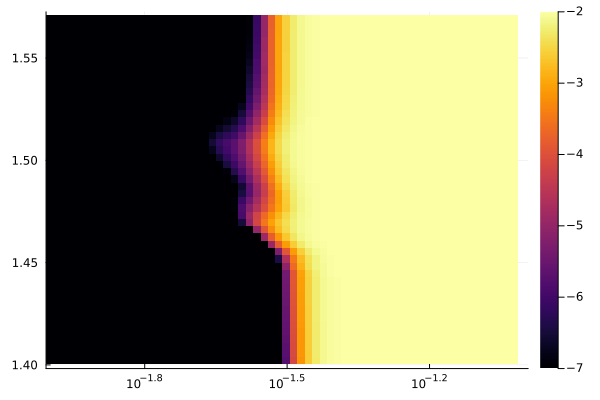

In [11]:
############################################################
# Example for calculations
##############################

ppd = jade.ppd_t(  );
ppd.calc_coag = true;
ppd.f_sub_raw = jade.gen_sublimation_interp(
#     "Graphene_sublimation.csv" );
    "MgFeSiO4_sublimation.csv" );    
#     "MgSiO3_sublimation.csv" );

r_min_au = 0.01
r_max_au = 0.1
vr0      = 1e-1;
vr_floor = 1e-1;
tlim     = r_max_au * jade.AU / vr0 * 10;
tlim     = min( tlim, 1e4 * jade.yr );
println( "tlim = ", tlim / jade.yr, " yr." );

jade.f_init!( ppd, n_mbin = 20,
              r_min_au = r_min_au, 
              r_max_au = r_max_au,
              n_r = 64, n_th = 48, th_min = 1.4,
              v0 = vr0, v_floor = vr_floor )
jade.f_intg_ray!( ppd );

jade.f_intg_dust!( ppd, 1e1 * tlim )
jade.f_major_loop!( ppd, nlim = 200, tlim = tlim,
                    n_osd = 10, dt0 = tlim )

r, th, rho_m = jade.f_get_heatmap_stat!( ppd, jade.f_rho_m )
r, th, rho_g = jade.f_get_heatmap_stat!( ppd, jade.f_rho_g )
heatmap( r, th, transpose( log10.(
    abs.( rho_m ./ rho_g ) .+ 1e-15 ) ),
              xscale = :log10, clim = ( -7, -2 ) )

############################################################

In [12]:
############################################################
# Extract data and save for Python plots
##############################

r_f, th_f, d_g_ratio = jade.f_get_heatmap_stat!(
                       ppd, jade.f_dust_mass_ratio! );
_, _, rho_g      = jade.f_get_heatmap_stat!( ppd,
                                             jade.f_rho_g );
_, _, rho_m_tot  = jade.f_get_heatmap_stat!( ppd,
                                             jade.f_rho_m );
_, _, T_res      = jade.f_get_heatmap_stat!( ppd,
                                             jade.f_T     );
r_c, th_c, rho_m = jade.f_extract_rho_m!(    ppd );

npzwrite( "adv/MgFeSiO4/data_no_acc.npz", Dict(
    "r_f" => r_f, "th_f" => th_f, "d_g_ratio" => d_g_ratio,
    "r_c" => r_c, "th_c" => th_c, "rho_m" => rho_m,
    "T" => T_res, "rho_m_tot" => rho_m_tot, "dx" => ppd.dx,
    "m_arr" => ppd.cdat.m_arr, "a_arr" => ppd.cdat.a_arr
) );

############################################################